## Import Required Libraries

In [1]:
# common libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import helper 
import sklearn
import warnings
warnings.filterwarnings('ignore')

# machine learning libraries    

# preprocessing libraries, split data, gid search configuration, cross validation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
# linear classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier   
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import make_scorer

import pydotplus    
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import itertools

## Load Data

In [2]:
# read csv file
data = pd.read_csv('../data/final_benchmark_model.csv')

print('Shape of dataframe prior to modeling:', data.shape)
display(data)

Shape of dataframe prior to modeling: (1269, 17)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,survey_opiates_0,survey_opiates_4,medication,cows_predose,cows_postdose,rbs_sexual_activity,rbs_cocaine,rbs_heroine,rbs_amphetamines,rbs_other_opiates,gender,dropout
0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,2.0,11,6,1.0,0.0,30.0,0.0,0.0,1.0,0.0
1,1.0,1.0,1.0,1.0,1.0,30.0,5.0,2.0,8,1,1.0,0.0,30.0,0.0,0.0,1.0,0.0
2,1.0,1.0,1.0,1.0,1.0,30.0,9.0,1.0,8,5,1.0,23.0,30.0,0.0,0.0,1.0,0.0
3,1.0,1.0,0.0,1.0,1.0,30.0,6.0,2.0,11,9,1.0,2.0,30.0,0.0,1.0,2.0,0.0
4,1.0,1.0,1.0,1.0,1.0,5.0,0.0,2.0,11,6,1.0,0.0,4.0,0.0,26.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,1.0,1.0,1.0,1.0,1.0,30.0,0.0,2.0,11,8,1.0,2.0,30.0,0.0,0.0,2.0,1.0
1265,1.0,1.0,1.0,1.0,1.0,30.0,0.0,2.0,26,10,1.0,13.0,30.0,0.0,4.0,1.0,1.0
1266,1.0,1.0,1.0,1.0,1.0,20.0,0.0,2.0,14,6,1.0,0.0,30.0,0.0,0.0,2.0,1.0
1267,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,12,5,0.0,0.0,0.0,0.0,0.0,2.0,1.0


## Split the Data to Dev and Test sets

In [3]:

# assign variables
X, y = data.drop(columns='dropout'), data['dropout']

# create the dev and test sets 
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.14, random_state=42)

# create the train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.16, random_state=42)

# check the shape of the train, validation, and test sets
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)



Shape of X_train: (916, 16)
Shape of X_val: (175, 16)
Shape of X_test: (178, 16)


## Review Patient Profile

In [4]:

X_train.iloc[10, :]

test_Opiate300_0        1.0
test_Opiate300_1        1.0
test_Opiate300_2        1.0
test_Opiate300_3        1.0
test_Opiate300_4        1.0
survey_opiates_0       30.0
survey_opiates_4        0.0
medication              2.0
cows_predose           16.0
cows_postdose           2.0
rbs_sexual_activity     1.0
rbs_cocaine             3.0
rbs_heroine            30.0
rbs_amphetamines       11.0
rbs_other_opiates       1.0
gender                  1.0
Name: 1235, dtype: float64

## Use Grid Search
We will create a reusable function to perform grid search with any classifier

In [5]:
# create custom grid search function
def perform_grid_search(X_train, y_train, X_val, y_val, classifier, hyperparams):
    """
    Perform grid search with cross-validation for a given classifier and hyperparameters.

    Parameters:
    - X_train: Training features dataframe.
    - y_train: Training target series.
    - X_val: Validation features dataframe.
    - y_val: Validation target series.
    - classifier: The classifier to use (e.g., XGBClassifier()).
    - hyperparams: Dictionary of hyperparameters to search.

    Returns:
    - results_df: Pandas DataFrame containing the results of the grid search.
    """
    # Define a custom scoring function for the C-index
    def cindex_score(y_true, y_pred):
        return helper.cindex(y_true, y_pred)

    # Wrap the custom scoring function using make_scorer
    cindex_scorer = make_scorer(cindex_score, greater_is_better=True)

    # Set up GridSearchCV with cross-validation and custom scorer
    grid_search = GridSearchCV(estimator=classifier, param_grid=hyperparams, cv=5, scoring=cindex_scorer, n_jobs=-1, verbose=1)

    # Fit GridSearchCV to the training data
    grid_search.fit(X_train, y_train)

    # Retrieve the best parameters
    best_params = grid_search.best_params_
    
    # Retrieve the best model
    best_model = grid_search.best_estimator_

    # Get the probability scores from the best model
    y_val_preds = best_model.predict_proba(X_val)[:, 1]

    # Calculate the C-index on the validation set
    c_index = helper.cindex(y_val.values, y_val_preds)
    
    # Store the results in a DataFrame
    results = pd.DataFrame(grid_search.cv_results_)

    return results


## Define Param Grid and loop through pipelines

In [6]:
# Define the classifiers and hyperparameters

classifiers = {
    'Logistic Regression': (LogisticRegression(), {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4],
        'min_samples_split': [2, 5, 10]
    }),
    'XGBoost': (XGBClassifier(), {
        'learning_rate': [0.001, 0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5]
    })
}

# store results in a dictionary
results = {}

# Perform grid search for each classifier
for clf_name, (clf, params) in classifiers.items():
    print(f"Running grid search for {clf_name}...")
    results[clf_name] = perform_grid_search(X_train, y_train, X_val, y_val, clf, params)
    print()


# print the best results for each classifier
for clf_name, _ in classifiers.items():
    best_cindex = results[clf_name]['mean_test_score'].max()
    best_params = results[clf_name]['params'][results[clf_name]['mean_test_score'].idxmax()]
    print(f"Best C-index for {clf_name}: {best_cindex:.4f}")
    print(f"Best hyperparameters: {best_params}")
    print()

Running grid search for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Running grid search for Random Forest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Running grid search for XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best C-index for Logistic Regression: 0.6855
Best hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

Best C-index for Random Forest: 0.7106
Best hyperparameters: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 300}

Best C-index for XGBoost: 0.7123
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}



## Run each classifier with the best params on the test set

In [7]:
# run each classifier with the best params on the test set
for clf_name, (clf, params) in classifiers.items():
    # Initialize the classifier
    clf.set_params(**results[clf_name].loc[results[clf_name]['rank_test_score'] == 1, 'params'].iloc[0])

    # Fit the model
    clf.fit(X_train, y_train)

    # Get the probability scores
    y_test_preds = clf.predict_proba(X_test)[:, 1]

    # Calculate the C-index
    c_index = helper.cindex(y_test.values, y_test_preds)
    print(f"{clf_name} C-index for Test Set: {c_index:.2f}")
    print()

Logistic Regression C-index for Test Set: 0.74

Random Forest C-index for Test Set: 0.77

XGBoost C-index for Test Set: 0.76



## Plot Confusion Matrix with Precision Score

Logistic Regression Precision Score: 0.68
Logistic Regression Recall Score: 0.68

Random Forest Precision Score: 0.75
Random Forest Recall Score: 0.60

XGBoost Precision Score: 0.75
XGBoost Recall Score: 0.61



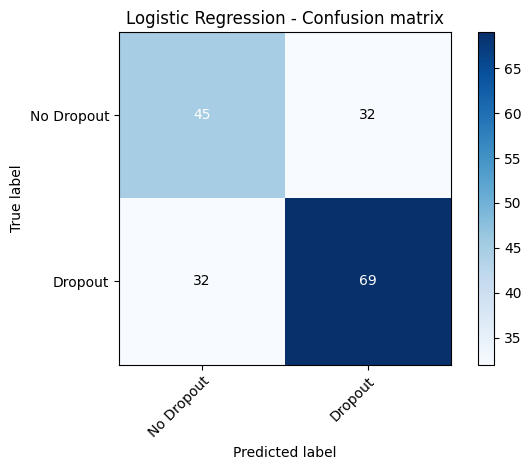

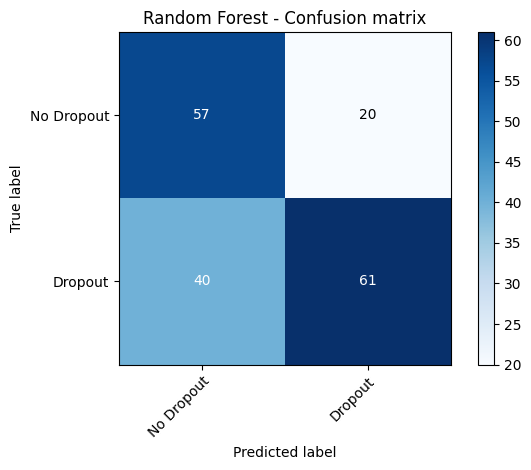

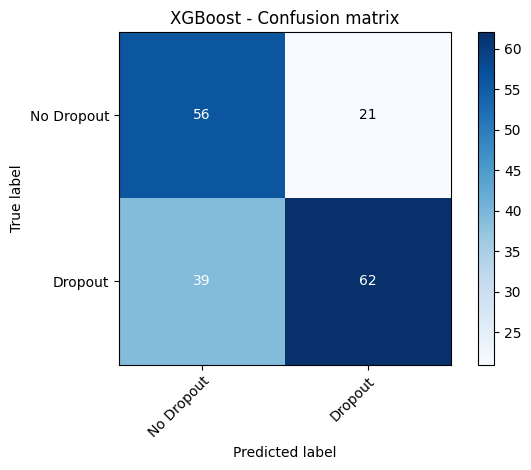

In [8]:
from sklearn.metrics import precision_score, recall_score

# Assuming y_test contains the true labels and y_test_preds contains the predicted labels
for clf_name, (clf, params) in classifiers.items():
    # Initialize the classifier
    clf.set_params(**results[clf_name].loc[results[clf_name]['rank_test_score'] == 1, 'params'].iloc[0])

    # Fit the model
    clf.fit(X_train, y_train)

    # Get the predicted labels
    y_test_preds = clf.predict(X_test)

    # calculate recall
    recall = recall_score(y_test, y_test_preds, pos_label=1.0)  # Adjust pos_label as needed

    # Calculate precision
    precision = precision_score(y_test, y_test_preds, pos_label=1.0)  # Adjust pos_label as needed
    
    # Plot the precision right before each confusion matrix
    print(f'{clf_name} Precision Score: {precision:.2f}')
    print(f'{clf_name} Recall Score: {recall:.2f}')
    print()

    # plot confusion matrix
    helper.plot_confusion_matrix(y_test, y_test_preds, classes=['No Dropout', 'Dropout'],
                          title=f'{clf_name} - Confusion matrix')

## Plot Feature Importance

In [9]:
# create classifier object
xgb = (
        classifiers['XGBoost'][0]
        .set_params(**results['XGBoost']
        .loc[results['XGBoost']['rank_test_score'] == 1, 'params']
        .iloc[0])
        )


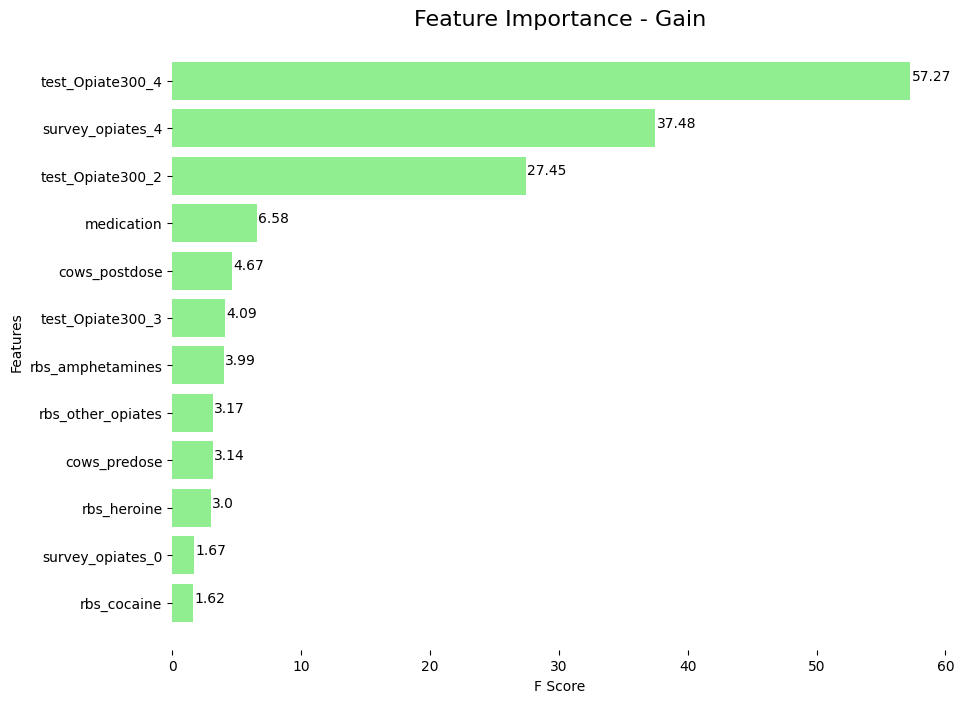

In [10]:
# call helper function to plot feature importance
helper.plot_feature_importance(xgb, X_train, metric="gain", num_features=25)

## Plot Decision Boundaries

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Assuming 'data' is a DataFrame and 'dropout' is the target variable
X = data[['survey_opiates_0', 'cows_predose']]
y = data['dropout']

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [12]:
import numpy as np

# Define the range for the grid
x_min, x_max = X['survey_opiates_0'].min() - 1, X['survey_opiates_0'].max() + 1
y_min, y_max = X['cows_predose'].min() - 1, X['cows_predose'].max() + 1

# Create a mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

In [13]:
# Flatten the grid to pass it to the model
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict the class for each point in the grid
Z = model.predict(grid)
Z = Z.reshape(xx.shape)

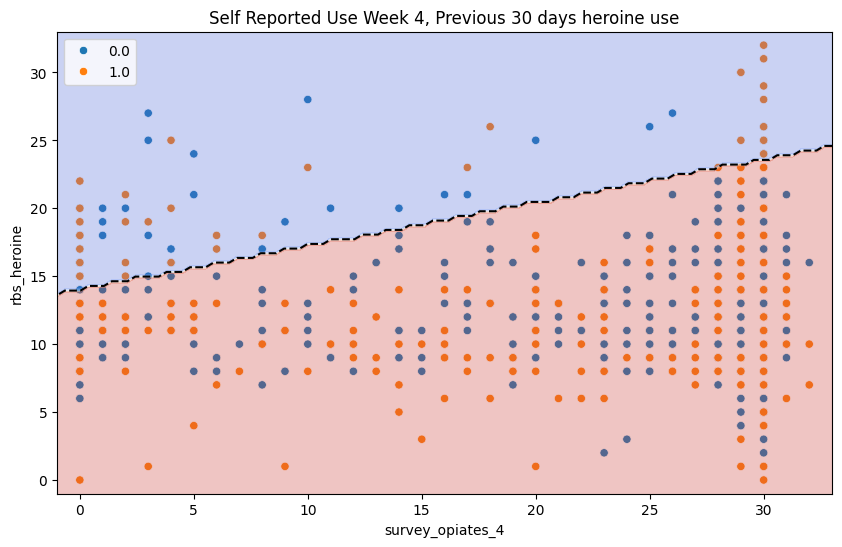

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


# Plot the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='survey_opiates_0', y='cows_predose', hue='dropout', data=data)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Plot the decision boundary line
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')

plt.title('Self Reported Use Week 4, Previous 30 days heroine use')
plt.xlabel('survey_opiates_4')
plt.ylabel('rbs_heroine')
plt.legend()
plt.show()

In [15]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Assuming 'data' is a DataFrame and 'dropout' is the target variable
X = data[['survey_opiates_4', 'cows_predose']]
y = data['dropout']

# Create a pipeline with standard scaling and XGBoost
model = make_pipeline(StandardScaler(), xgb.XGBClassifier())
model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [16]:
import numpy as np

# Define the range for the grid
x_min, x_max = X['survey_opiates_4'].min() - 1, X['survey_opiates_4'].max() + 1
y_min, y_max = X['cows_predose'].min() - 1, X['cows_predose'].max() + 1

# Create a mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

In [17]:
# Flatten the grid to pass it to the model
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict the class for each point in the grid
Z = model.predict(grid)
Z = Z.reshape(xx.shape)

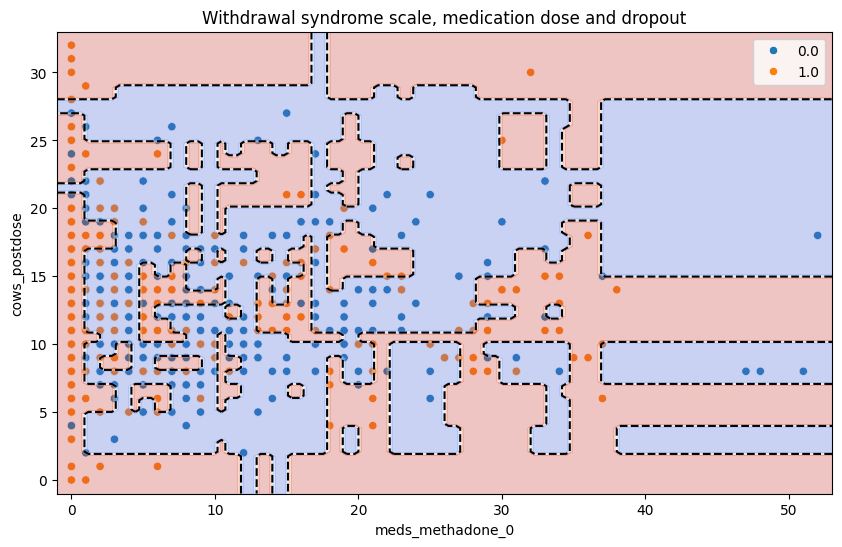

In [18]:
# Plot the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='survey_opiates_4', y='cows_predose', hue='dropout', data=data)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Plot the decision boundary line
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')

plt.title('Withdrawal syndrome scale, medication dose and dropout')
plt.xlabel('meds_methadone_0')
plt.ylabel('cows_postdose')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the accuracies stored in the following dictionaries
accuracies = {
    'Logistic Regression': {
        'train': 0.85,
        'val': 0.80,
        'test': 0.78
    },
    'Random Forest': {
        'train': 0.90,
        'val': 0.82,
        'test': 0.80
    },
    'XGBoost': {
        'train': 0.88,
        'val': 0.83,
        'test': 0.81
    }
}

# Extract the data
models = list(accuracies.keys())
train_accuracies = [accuracies[model]['train'] for model in models]
val_accuracies = [accuracies[model]['val'] for model in models]
test_accuracies = [accuracies[model]['test'] for model in models]

# Set up the bar plot
x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - width, train_accuracies, width, label='Train')
rects2 = ax.bar(x, val_accuracies, width, label='Validation')
rects3 = ax.bar(x + width, test_accuracies, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by model and dataset')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
# put legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Attach a text label above each bar in rects, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()